# Gaussian Processes
N. Bartoli ONERA/DTIS/M2CI


This tutorial describes how to use 
- the pyDOE2 library to build a Design of Experiments (pyDOE2 is the updated version of pyDOE)
- the Gaussian Process based on the **scikit-learn toolbox**
[Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011]


<div class="alert alert-warning fade in" id="d107"><h4 id="this-is-an-example-alert-message-">**Four main steps**</h4>
<hr>
<ol>
<li>We have to create the training points by using a design of experiments.</li>
<li>Then, we create an object of the class Gaussian Process Regressor (with some options)</li>
<li>To finish, we do the GP models by applying the *'fit'* function</li>
  <li>  To apply your GP model with the *'predict'* function
</ol>
</div>

<p class="alert alert-success" style="padding:1em">
Another option is to use SMT toolbox (Surrogate Modeling Toolbox) where on focus on derivatives is made. The surrogate modeling toolbox (SMT) is an open-source Python package consisting of libraries of surrogate modeling methods (e.g., radial basis functions, kriging), sampling methods, and benchmarking problems.
Please follow this link : https://github.com/SMTorg/SMT/blob/master/README.md. The doc is available here: http://smt.readthedocs.io/en/latest/
</p>

In order to train a GP model $\mathcal{G} = \lbrace \mathbf{X}, \mathbf{y}, \Theta \rbrace$ using the Squared Exponential kernel 
$$k(x,x') =\sigma^2\exp\left(-\sum_j^d{\theta_j(x_j-x_j')^2}\right)$$
where $x\in \mathbb{R}^d$ and $x' \in \mathbb{R}^d$

Given the Design of Eperiments with $N$ input data $\mathbf{y} = \left[y_1,\ldots,y_N\right]$ and $\mathbf{X} =  \left[x_1,\ldots,x_N\right]$ with $x_i\in \mathbb{R}^d$ and $y_i\in \mathbb{R}$
and given a covariance kernel $k(x,x')$, a Gaussian Process (also known as ordinary Kriging) estimates the distribution of $Y(x)$ as a Gaussian law $\mathcal{N}(\mu_y,\sigma_y)$ with: 
$$\mu_y(x) = r_*(x)R^{-1} \mathbf{y}$$
$$\sigma_y^2(x) = k(x,x) - r_*(x)R^{-1}r_*(x)^t$$ 
where the covariance matrix $R$ and the vector of covariances $r_*(x)$ are given by   
$$R =
\begin{bmatrix}
k(x_1,x_1) & \ldots & k(x_1,x_N) \\
\vdots     & \ddots & \vdots \\
k(x_1,x_N) & \ldots & k(x_N,x_N)
\end{bmatrix}, \
r_*(x) = \left[k(x_1, x), \ldots, k(x_N,x)\right]$$

# A Quick overview in 1D with sin(x) function

In [1]:
# Author: Vincent Dubourg <vincent.dubourg@gmail.com>
#         Jake Vanderplas <vanderplas@astro.washington.edu>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>s
# License: BSD 3 clause

%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel


import warnings
warnings.filterwarnings('ignore') #to remove warning messages

np.random.seed(1)

def f(x):
    """The function to predict."""
    return x * np.sin(x)

<div class="alert alert-info fade in" id="d110">
<p>The idea is to try to build  a GP model by yourself using the equations given above</p>    
<ol> -  using fixed valued for the hyperparameters </ol>
<ol> - with optimization of the hyperparameters  </ol>
</div>

In [2]:
#here all the functions are given to compute equations given above
def covariance_function(x_1,x_2,theta,sig):
    theta = np.asarray(theta)
    dist2 = (x_1-x_2)**2
    k_12 = (sig**2) * np.exp(- np.sum(theta**2 * dist2))
    return k_12

def covariance_matrix(points,theta,sig):
    theta = np.asarray(theta)
    N = points.shape
    R = np.zeros((N[0],N[0]))
    for i,point in enumerate(points):
        R[:,i] = np.array([covariance_function(point,point_1,theta,sig) for point_1 in points])
    return R

def covariance_vect(x,points,theta,sig):
    theta = np.asarray(theta)
    r = np.array([covariance_function(x,x_i,theta,sig) for x_i in points])
    return r

def myGPpredict(x_new, x_doe, y_doe, R_inv, theta, sig):
    r_star = covariance_vect(x_new,x_doe,theta,sig)
    mu = r_star.dot(R_inv.dot(y_doe))[0]
    r_xx = covariance_function(x_new,x_new,theta,sig)
    sigma2 = r_xx - r_star.dot(R_inv.dot(r_star.T)) #sigma * sigma
    sigma = np.sqrt(sigma2)
    return mu,sigma

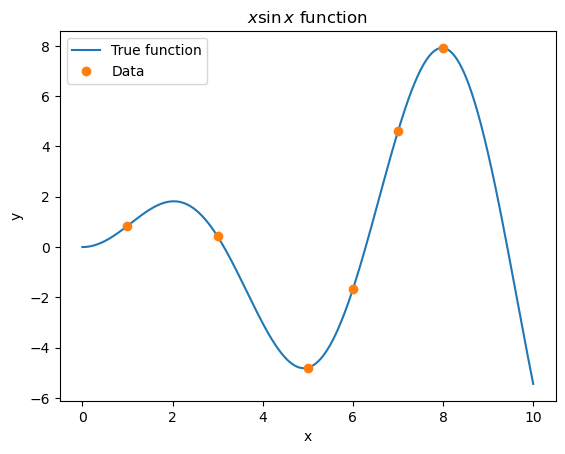

In [3]:
from sklearn.metrics import mean_squared_error, r2_score

#validation set
xtest = np.atleast_2d(np.linspace(0,10,100)).T
ytest = f(xtest)

#doe
x_doe = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T
y_doe = f(x_doe)

#to plot the function
xplot = np.atleast_2d(np.linspace(0,10,1000)).T
yplot = f(xplot)

lines = []
fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(xplot,yplot)
data, = ax.plot(x_doe,y_doe,linestyle='',marker='o')
lines.append(true_fun)
lines.append(data)
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(lines,['True function','Data'])
plt.show()

In [4]:
#choices for hyperparameters
theta = 1./3.
sig = 1.

RMSE = 2.10686 (should be close to 0)
R2 = 0.84673 (should be close to 1)


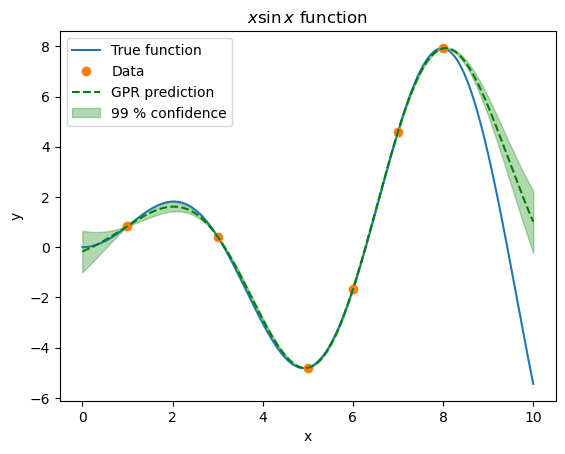

In [5]:
R = covariance_matrix(x_doe,theta,sig)
R_inv = np.linalg.inv(R)

ypred = np.array([myGPpredict(xt,x_doe,y_doe,R_inv,theta,sig) \
                   for xt in xtest])


RMSE = mean_squared_error(ytest,ypred[:,0])
R2 = r2_score(ytest,ypred[:,0])

print('RMSE = %.5f (should be close to 0)' %(RMSE))
print('R2 = %.5f (should be close to 1)' %(R2))

y_GP_plot = np.array([myGPpredict(xt,x_doe,y_doe,R_inv,theta,sig) \
                   for xt in xplot])

fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(xplot,yplot)
data, = ax.plot(x_doe,y_doe,linestyle='',marker='o')
gp, = ax.plot(xplot,y_GP_plot[:,0],linestyle='--',color='g')
un_gp = ax.fill_between(xplot.T[0],y_GP_plot[:,0]+3*y_GP_plot[:,1],y_GP_plot[:,0]-3*y_GP_plot[:,1],alpha=0.3,color='g')
lines = [true_fun,data,gp,un_gp]
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(lines,['True function','Data','GPR prediction','99 % confidence'])
plt.show()

### Try to change the value of `theta` and `sig` fixed above to see what happens.


### The idea is to train the fnd the optimal values for hyperparameters (`theta` and `sig`)

To train the model, the negative log marginal likelihood with respect to the hyper-parameters has to be minimized:

$$-\text{log}\, p(\mathbf{y} \mid \mathbf{X}, \theta) = \frac{N}{2} \log(\frac{\mathbf{y}^\top\mathbf{R}^{-1}\mathbf{y}}{R}) + \frac{1}{2}\log\mid\mathbf{R}\mid $$

where the covariance matrix $\mathbf{R}$ is a function of the hyper-parameters ($\theta$ and $\sigma$) and $\mid\mathbf{R}\mid$ is the determinant. $N $ is the number of training points.

We want to plot a 1D graph of  this function for different values of $\theta$ (and $\sigma$ is constant) 


Optimization results with scipy  message: Optimization terminated successfully
 success: True
  status: 0
     fun: 6.0096409341361205
       x: [ 4.219e-01]
     nit: 19
     jac: [ 1.250e-02]
    nfev: 48
    njev: 18

Best theta is 0.42193 with sigma= 1.00000


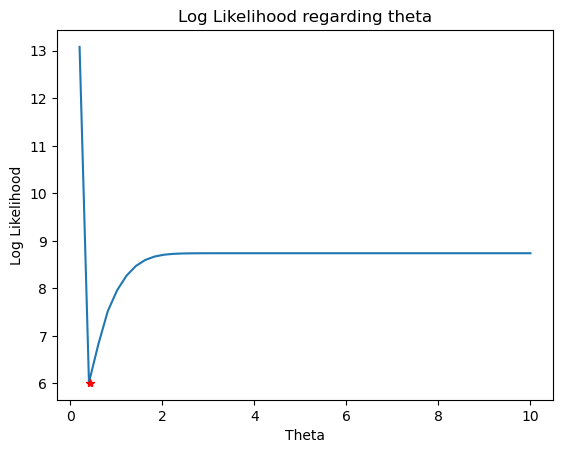

In [6]:
def likelihood(x_doe,y_doe,theta,sig):
    R = covariance_matrix(x_doe,theta,sig)
    N=x_doe.shape[0]
    term1 = y_doe.T.dot(np.linalg.inv(R))
    term2 = np.log(term1.dot(y_doe)/N)
    term3 = np.log(np.linalg.det(R))
  
    output = N/2.*term2 + 1./2.*term3
    return output[0][0]

#to plot the likelihood function 
theta = np.linspace(1e-3,10)
like = np.array([likelihood(x_doe,y_doe,th,sig) for th in theta])
fig = plt.figure()
ax = fig.add_subplot(111)
line = ax.plot(theta,like)
ax.set_xlabel('Theta')
ax.set_ylabel('Log Likelihood')
ax.set_title('Log Likelihood regarding theta')

#to minimize the likelihood function using scipy algorithm
from scipy.optimize import minimize

like_obj = lambda theta : likelihood(x_doe,y_doe,theta,sig)

# Multistart to remove bad optimization results
theta_start = np.linspace(1e-2,25,10) #to start with 10 initial starting points

opt_all = np.array([minimize(like_obj, th, method='SLSQP', bounds=[(1e-2,25)]) for th in theta_start])
opt_success = opt_all[[opt_i['success'] for opt_i in opt_all]]
obj_success = np.array([opt_i['fun'] for opt_i in opt_success])
ind_min = np.argmin(obj_success)

opt = opt_success[ind_min]
theta_opt = opt['x']

print('Optimization results with scipy', opt)
print('')
print('Best theta is %.5f with sigma= %.5f' %(theta_opt, sig) )
plt.plot(theta_opt,like_obj(theta_opt),'r*')

### As the optimal value of theta is found we can plot the associated GP on the initial function 

RMSE = 3.75012 (should be close to 0)
R2 = 0.72719 (should be close to 1)


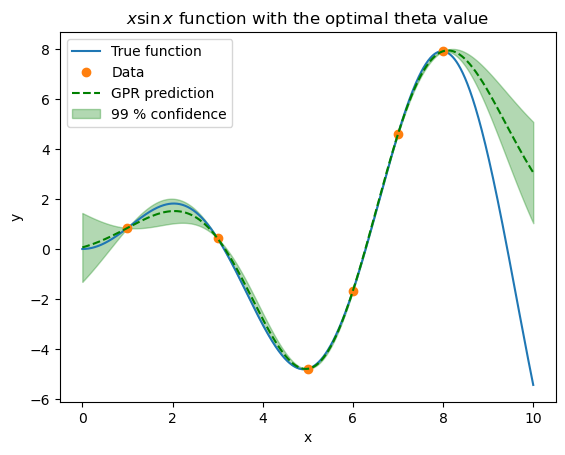

In [7]:
#choices for hyperparameters
theta = theta_opt
sig = 1.
R = covariance_matrix(x_doe,theta,sig)
R_inv = np.linalg.inv(R)

ypred = np.array([myGPpredict(xt,x_doe,y_doe,R_inv,theta,sig) \
                   for xt in xtest])


RMSE = mean_squared_error(ytest,ypred[:,0])
R2 = r2_score(ytest,ypred[:,0])

print('RMSE = %.5f (should be close to 0)' %(RMSE))
print('R2 = %.5f (should be close to 1)' %(R2))

y_GP_plot = np.array([myGPpredict(xt,x_doe,y_doe,R_inv,theta,sig) \
                   for xt in xplot])

fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(xplot,yplot)
data, = ax.plot(x_doe,y_doe,linestyle='',marker='o')
gp, = ax.plot(xplot,y_GP_plot[:,0],linestyle='--',color='g')
un_gp = ax.fill_between(xplot.T[0],y_GP_plot[:,0]+3*y_GP_plot[:,1],y_GP_plot[:,0]-3*y_GP_plot[:,1],alpha=0.3,color='g')
lines = [true_fun,data,gp,un_gp]
ax.set_title('$x \sin{x}$ function with the optimal theta value')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(lines,['True function','Data','GPR prediction','99 % confidence'])
plt.show()

<div class="alert alert-info fade in" id="d110">
<p>The idea is now to compare on a simple 1D example using `sklearn toolbox`</p>    
<ol> -  a GP interpolation model </ol>
<ol> - a GP regression model when noise is considered  </ol>
</div>

## a 1D noiseless case

In [8]:
# ----------------------------------------------------------------------
#  First the noiseless case
X = x_doe

# Observations
y = f(X).ravel()

In [9]:
# Instanciate a Gaussian Process model
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
#n_restarts_optimizer is the  number of restarts of the optimizer for finding the kernel’s parameters which maximize the log-marginal likelihood. 
#normalize_y : to normalize the target values y
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(xtest, return_std=True)

RMSE = 3.75012 (should be close to 0)
R2 = 0.72719 (should be close to 1)


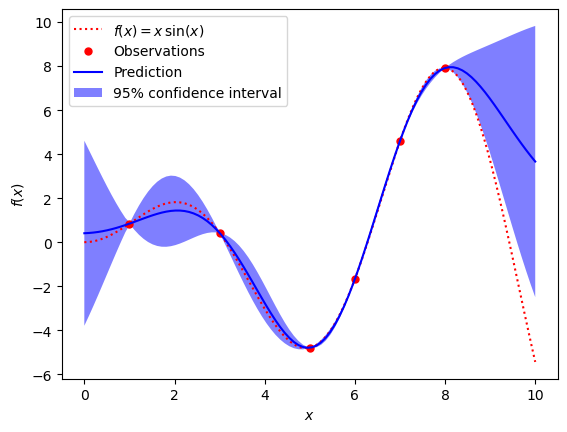

In [10]:
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(xplot, f(xplot), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(x_doe, y_doe, 'r.', markersize=10, label=u'Observations')
plt.plot(xtest, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([xtest, xtest[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
#plt.ylim(-10, 20)
plt.legend(loc='upper left')


RMSE = mean_squared_error(ytest,ypred[:,0])
R2 = r2_score(ytest,ypred[:,0])

print('RMSE = %.5f (should be close to 0)' %(RMSE))
print('R2 = %.5f (should be close to 1)' %(R2))

## a 1D noisy case

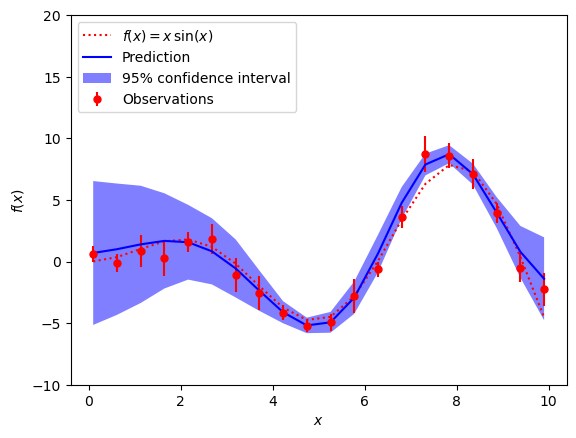

In [11]:
# ----------------------------------------------------------------------
# now the noisy case
X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Instanciate a Gaussian Process model
#alpha corresponds to the noise and will ensure to give a positive definite matrix.
#different values of alpha could be done: a constant value, a function dy, dy/y, ...
gp = GaussianProcessRegressor(kernel=kernel, alpha=(dy / y) ** 2,
                              n_restarts_optimizer=10, normalize_y=True)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(X, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(X, f(X), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label=u'Observations')
plt.plot(X, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([X, X[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

plt.show()

<div class="alert alert-info fade in" id="d110">
<p>For more complex systems, we use a design of experiments</p>
 <ol> - create a DOE with PyDOE2 toolbox </ol>
  <ol>  - download a database (DOE files) </ol>


</div>


# 2. Installation of pyDOE

The package pyDOE2 (a fork from pyDOE where Bugs have been solved) which handles the creation of the domain of experiment.

<div class="alert alert-warning fade in" id="d107"><h4 id="this-is-an-example-alert-message-">
    
In your cmd window:

pip install pyDOE2 or !pip install pyDOE2 in the notebook
</div>


In [12]:
!pip install pyDOE2

# 3. Construction of the training points for a 2D example

## 3.1 Case 1: the user doesn't have any sample

[[-1.         -1.        ]
 [-1.         -0.66666667]
 [-1.         -0.33333333]
 [-1.          0.        ]
 [-1.          0.33333333]
 [-1.          0.66666667]
 [-1.          1.        ]
 [-0.66666667 -1.        ]
 [-0.66666667 -0.66666667]
 [-0.66666667 -0.33333333]
 [-0.66666667  0.        ]
 [-0.66666667  0.33333333]
 [-0.66666667  0.66666667]
 [-0.66666667  1.        ]
 [-0.33333333 -1.        ]
 [-0.33333333 -0.66666667]
 [-0.33333333 -0.33333333]
 [-0.33333333  0.        ]
 [-0.33333333  0.33333333]
 [-0.33333333  0.66666667]
 [-0.33333333  1.        ]
 [ 0.         -1.        ]
 [ 0.         -0.66666667]
 [ 0.         -0.33333333]
 [ 0.          0.        ]
 [ 0.          0.33333333]
 [ 0.          0.66666667]
 [ 0.          1.        ]
 [ 0.33333333 -1.        ]
 [ 0.33333333 -0.66666667]
 [ 0.33333333 -0.33333333]
 [ 0.33333333  0.        ]
 [ 0.33333333  0.33333333]
 [ 0.33333333  0.66666667]
 [ 0.33333333  1.        ]
 [ 0.66666667 -1.        ]
 [ 0.66666667 -0.66666667]
 

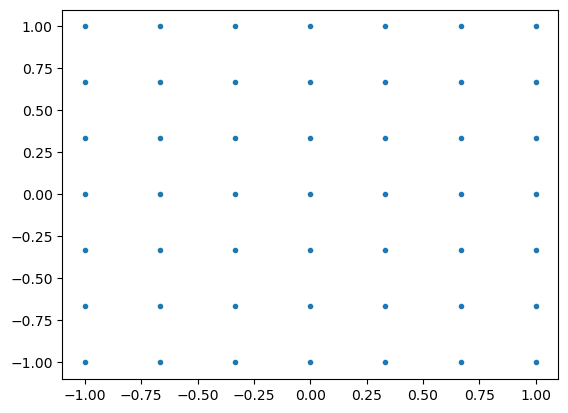

In [13]:
from pyDOE2 import *

import numpy as np
import matplotlib.pyplot as plt

# construction of both test and training points (the user doesn't have any validation point)
x_min=[-1 , -1]
x_max=[1 , 1] 
num=7
# grid pattern
x_array = np.linspace(x_min[1], x_max[1], num)
y_array = np.linspace(x_min[1], x_max[1], num)

mapping_array = []

for i in range(len(x_array)):
    for j in range(len(y_array)):
        mapping_array.append([x_array[i], y_array[j]])
x_train_and_test=np.array(mapping_array);

print(x_train_and_test)
plt.plot(x_train_and_test[:,0],x_train_and_test[:,1],'.')
plt.show()

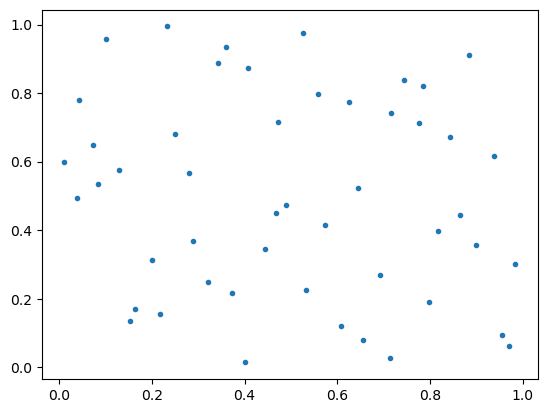

In [14]:
from pyDOE2 import *

dim = 2 # dimension of the problem
#DOE with classical LHS
x_train_and_test = lhs(dim, samples=49)
#print(x_train_and_test)
plt.plot(x_train_and_test[:,0],x_train_and_test[:,1],'.')
plt.show()

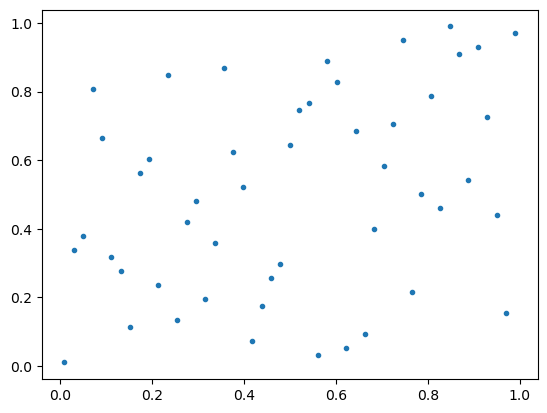

In [15]:
#DOE with classical LHS
x_train_and_test = lhs(dim, samples=49, criterion='center')
#print(x_train_and_test)
plt.plot(x_train_and_test[:,0],x_train_and_test[:,1],'.')
plt.show()

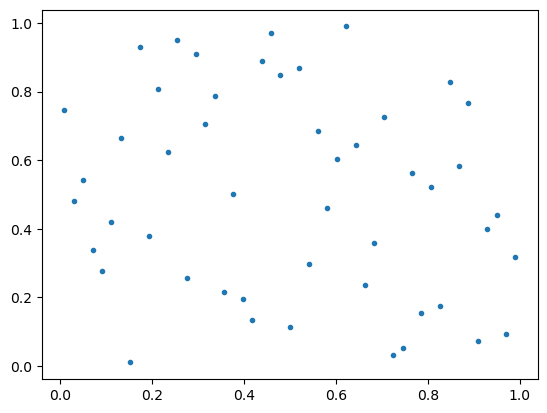

In [16]:
#DOE with classical LHS
x_train_and_test = lhs(dim, samples=49, criterion='centermaximin')
#print(x_train_and_test)
plt.plot(x_train_and_test[:,0],x_train_and_test[:,1],'.')
plt.show()

The outputs y are created by applying the function we want to model.

  

To split the training set and the test set we can use the function:

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(x_train_and_test, test_size=0.2, random_state=12)
print('X_train', x_train_and_test.shape)
print('X_train', x_train.shape)
print('X_test', x_test.shape)

X_train (49, 2)
X_train (39, 2)
X_test (10, 2)


## 3.2 Define the Branin function and visualize it

**Branin function**
$$
\begin{array}{ccc}
f(x_1,x_2) = {\left(x_{2} - \frac{5.1}{4\pi^2} {x_{1}}^2 + \frac{5}{\pi} x_{1} - 6\right)}^2 + 10 \left[(1 - \frac{1}{8\pi}) \cos(x_{1}) + 10\right] 
\end{array}
$$

$$x_{1} \in [-5, 10] \hspace{2mm} x_{2} \in [0, 15]$$

In [18]:
def branin(x):
    """
    This function is the Branin function
    Input:
    --------
    x : 2D array_like (x in [0, 1])
    Output
    --------
    y : array_like
    values of Branin function for each x
    """
    if x.shape[1] != 2:
        raise UncorrectInputDimension()
    #vector x in [0, 1] =>  x1 in [-5, 10] and x2 in [0 15]
    x1 = 15 * x[:, 0] - 5
    x2 = 15 * x[:, 1]
    return (x2 - 5.1 / (4. * (np.pi)**2) * x1**2 + 5. / np.pi * x1 - 6)**2 + \
        10. * (1. - 1. / (8. * np.pi)) * np.cos(x1) + 10


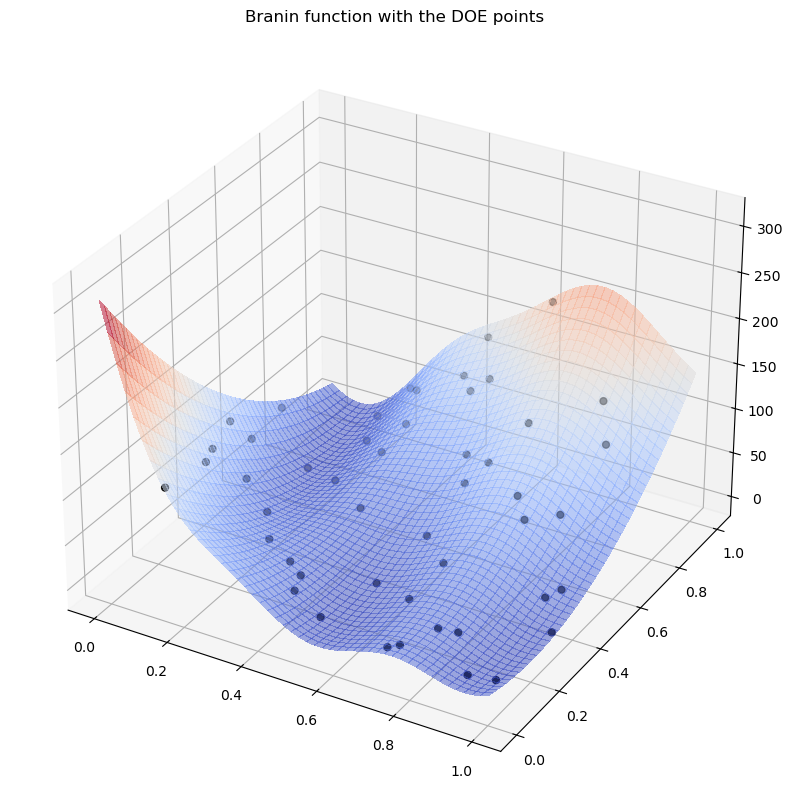

In [19]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

y_train_and_test = branin(x_train_and_test) # branin's function = function to model
x = np.linspace(0,1,50)
res = []
for x0 in x:
    for x1 in x:
        res.append(branin(np.array([[x0,x1]])))
res = np.array(res)
res = res.reshape((50,50)).T
X,Y = np.meshgrid(x,x)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(x_train_and_test[:,0],x_train_and_test[:,1],y_train_and_test,zdir='z',marker = '.',c='k',s=100)
surf = ax.plot_surface(X, Y, res, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,alpha=0.5)
plt.title('Branin function with the DOE points')

plt.show()

## 3.3 Case 2: the user does have sample of points

If the user has a file with points, he can also use the function 'construct_sample' to construct the samples 


<div class="alert alert-warning fade in" id="d107"><h4 id="this-is-an-example-alert-message-">
    
To read files from google colab

url_name='https://raw.githubusercontent.com/dbetteb/early-ML/master/07_DESIGN_EXPERIMENTS/BRANIN_Train.csv'

xy_train = pd.read_csv(url_name, header=None)

url_name='https://raw.githubusercontent.com/dbetteb/early-ML/master/07_DESIGN_EXPERIMENTS/BRANIN_Valid.csv'

xy_valid = pd.read_csv(url_name, header=None)

url_name='https://raw.githubusercontent.com/dbetteb/early-ML/master/07_DESIGN_EXPERIMENTS/BRANIN_Predict.csv'

xy_to_predict = pd.read_csv(url_name, header=None)

</div>

In [20]:
#or from local files
import pandas as pd

file_name = "BRANIN_Train.csv"
xy_train = pd.read_csv(file_name, header=None)


file_name = "BRANIN_Valid.csv"
xy_valid = pd.read_csv(file_name, header=None)


file_name = "BRANIN_Predict.csv"
xy_to_predict = pd.read_csv(file_name, header=None)


In [21]:
#to create the input and output sets

x_train = np.array(xy_train[[0,1]])
y_train = np.array(xy_train[2])
print(x_train[:,0])
print(y_train)

x_valid = np.array(xy_valid[[0,1]])
y_valid = np.array(xy_valid[2])
n_valid=np.shape(x_valid)[0]
print('Number of validation points', n_valid)
#print(x_valid)
#print(y_valid)

x_to_predict = np.array(xy_to_predict[[0,1]]) #we have only x in this case
#print(x_to_predict)


[0.09552949 0.83179357 0.74168267 0.17256091 0.03604282 0.74860049
 0.49934044 0.49208665 0.93461467 0.8807172  0.4336003  0.81867117
 0.72770336 0.04544719 0.70779226 0.54776238 0.63106205 0.30271909
 0.47501677 0.51989657 0.78904871 0.50032716 0.28300669 0.451041
 0.65817493 0.26837223 0.45659908 0.58942116 0.11127528 0.05809894
 0.011737   0.44648431 0.44126461 0.42039259 0.61827297 0.30944503
 0.38187072 0.9175683  0.96747286 0.21934246 0.27182861 0.35327685
 0.08920059 0.71064778 0.64731831 0.19494702 0.48465117 0.67296317
 0.86896429 0.55714943 0.20217391 0.13707021 0.19790894 0.92422119
 0.95084619 0.79732368 0.10800572 0.8591487  0.36760716 0.62474648
 0.76837823 0.99871062 0.77007737 0.46833664 0.39828836 0.95996673
 0.38567848 0.94129091 0.02761556 0.6665888  0.87661168 0.8851333
 0.25515471 0.47343552 0.43829043 0.32451046 0.82004619 0.40671456
 0.18203326 0.94699463 0.55139186 0.96035225 0.5098787  0.01970767
 0.68727324 0.1157061  0.24997308 0.54434092 0.4864107  0.5380911

NB: the form of the `csv` file is very specific. Open one to see how the data is filled in.  
Every point is in the first column. One row corresponds to one point. Each component of the point is separated by a comma without space.

We have so far constructed the training points and the validation points.

# 4. Building a Gaussian process 

<p class="alert alert-warning" style="padding:1em">**Reference** : Carl Eduard Rasmussen and Christopher K.I. Williams, “Gaussian Processes for Machine Learning”, 
MIT Press 2006, Link to an official complete PDF version of the book here: http://www.gaussianprocess.org/gpml/chapters/RW.pdf. </p>

In [22]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.metrics import mean_squared_error

## 4.1 Create the object GP Regressor

To create an object, the user just has to do define:
- the dimension of the data if you want to have anisotropic kernel
- the choice of the kernel (or the composition of different kernels)
- the choice of the optimizer for the hyperparameters (if =None, no optimization is done)
- the choice of the number of restarts for the optimization (to avoid local minima)
- the choice to add a normalization of your output data when your  values’ means  differ considerable from zero

In [23]:
# Kriging surrogate model with a RBF kernel (also called “squared exponential” kernel) which is a  infinitely differentiable
kernel = ConstantKernel(10, (1e-3, 1e5)) * RBF(10, (1e-3, 1e3))
gpr = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=20, normalize_y=True)
#To have some information about the function
help(GaussianProcessRegressor)

Help on class GaussianProcessRegressor in module sklearn.gaussian_process._gpr:

class GaussianProcessRegressor(sklearn.base.MultiOutputMixin, sklearn.base.RegressorMixin, sklearn.base.BaseEstimator)
 |  GaussianProcessRegressor(kernel=None, *, alpha=1e-10, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=0, normalize_y=False, copy_X_train=True, n_targets=None, random_state=None)
 |  
 |  Gaussian process regression (GPR).
 |  
 |  The implementation is based on Algorithm 2.1 of [RW2006]_.
 |  
 |  In addition to standard scikit-learn estimator API,
 |  :class:`GaussianProcessRegressor`:
 |  
 |     * allows prediction without prior fitting (based on the GP prior)
 |     * provides an additional method `sample_y(X)`, which evaluates samples
 |       drawn from the GPR (prior or posterior) at given inputs
 |     * exposes a method `log_marginal_likelihood(theta)`, which can be used
 |       externally for other ways of selecting hyperparameters, e.g., via
 |       Markov chain Monte Carl

## 4.2 Choice of the kernels

<div class="alert alert-info fade in" >
** The kernel specifies the covariance function of the GP. **
<p>You can combine also different kernels:</p>
 <ol> - Common kernels are provided (Constant, RBF or Squared exponentiel, Matern,...),  </ol>
  <ol>  - but it is also possible to specify custom kernels (sum, products, ...) . </ol>
</div>  

<p class="alert alert-danger" style="padding:1em">
If None is passed, the kernel “1.0 * RBF(1.0)” is used as default. Note that the kernel’s hyperparameters are optimized during fitting.
More details are given in http://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels
</p>

In [24]:
from sklearn.gaussian_process.kernels import (WhiteKernel, RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)

#examples of different kernels
kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
           1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.0, 10.0)) ** 2),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5)]

<div class="alert alert-warning fade in" id="d107"><h4 id="this-is-an-example-alert-message-">**Some examples to build non stationary kernel from GPR using ConstantKernel and DotProduct**</h4>

</div>

In [25]:
kernel_test= ConstantKernel(0.1, (0.01, 10.0)) + ConstantKernel(0.1, (0.01, 10.0))* (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.0, 10.0)) ** 2) + RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)) 

In [26]:
gpr_test = GaussianProcessRegressor(kernel=kernel_test)
gpr_test.fit(x_train, y_train)

GaussianProcessRegressor(kernel=0.316**2 + 0.316**2 * DotProduct(sigma_0=1) ** 2 + RBF(length_scale=1))

## 4.3 Produce the GPR models

To produce the GPR model, the user uses the 'fit' function .    
The user needs to have: 
- x : the training inputs (previously built)
- y : the training outputs (previously built)


In [27]:
# Fit to data using Maximum Likelihood Estimation of the parameters
gpr.fit(x_train, y_train)

GaussianProcessRegressor(kernel=3.16**2 * RBF(length_scale=10),
                         n_restarts_optimizer=20, normalize_y=True)

In [28]:
#kernel parameters
print("Learned Kernel with optimized parameters:%s" % gpr.kernel_)
#Value of theta
print('Parameters values', np.exp(gpr.kernel_.theta)) 


Learned Kernel with optimized parameters:6.92**2 * RBF(length_scale=0.308)
Parameters values [47.83177756  0.30827978]


<div class="alert alert-info fade in" >
**Isotropic or Anisotropic:**
<p>The RBF kernel is parameterized by a length-scale parameter length_scale>0,</p>
 <ol> -which can either be a scalar (isotropic variant of the kernel) </ol>
     <ol> -or a vector with the same number of dimensions as the inputs X (anisotropic variant of the kernel). </ol>     
 </div>  

<p class="alert alert-warning" style="padding:1em">
 In that case, the dimension of the initial parameter has to be specified 
</p>

In [29]:
dim=2
#kernel = ConstantKernel(10, (1e-3, 1e5)) * RBF([10]*dim, (1e-3, 1e3))
kernel = ConstantKernel(1.0, (1e-3, 1e3)) + 1.0 * Matern(length_scale=[1.0]*dim, length_scale_bounds=(1e-1, 10.0),nu=1.5)
gpr = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=20)
gpr.fit(x_train, y_train)
#kernel parameters
print("Learned Kernel with optimized parameters:%s" % gpr.kernel_)
#Value of theta
print('Parameters values', np.exp(gpr.kernel_.theta)) 


Learned Kernel with optimized parameters:31.6**2 + 316**2 * Matern(length_scale=[2.26, 6.49], nu=1.5)
Parameters values [1.00000000e+03 1.00000000e+05 2.25868624e+00 6.48624970e+00]


In [30]:
# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gpr.predict(x_valid, return_std=True)

In [31]:
y_pred, sigma

(array([ 27.4115606 , 124.10400644,  89.5299166 ,  10.8778506 ,
         44.93305102,  64.82411394,  15.5553632 ,  28.8014242 ,
         41.14868125, 119.24693883, 139.43151804,  61.80591935,
         21.27332204,  26.18283637,  24.02425597,  71.94045644,
         60.83011688,  60.97464832,  13.71392508,  96.81264653,
        116.41325763,   8.88880014,  25.23998045,  20.54405156,
          1.21037789,  12.66037851,  36.06348397,  75.38889753,
         27.16687823,  69.97563341,   7.3457192 ,  41.01382472,
          4.29859077,  19.16506306, 169.20046752, 140.41923957,
         67.67477262,  17.69369745,   9.0645331 ,   2.10807441]),
 array([0.24080034, 0.17459666, 0.72636135, 0.33144249, 0.38874019,
        0.54155814, 0.7667675 , 0.63729771, 0.26516715, 2.05358388,
        0.53084657, 0.83898673, 0.48044461, 0.15470052, 0.32385559,
        0.4165803 , 0.51161689, 0.41018778, 0.38758413, 0.56298717,
        0.55965989, 0.21094849, 0.3968027 , 0.27939881, 0.50815485,
        0.52003836

## 4.4 Normalization of the database

It can be sometimes useful to normalize the data set.

For instance, scikit-learn proposes some tools http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

Standardize features by removing the mean ($u$) and scaling to unit variance ($s^2$ is the variance, $s$ is the standard deviation) by using the formula
$$z = (x - u) / s$$
==> $z$ has now a zero mean and a unit variance

In [32]:
from sklearn.preprocessing import StandardScaler 
#Scaling of dataset
scalerX = StandardScaler()
x_trainN = scalerX.fit_transform(x_train)
scalerY = StandardScaler()
#to ensure to have a 1D vector for Y
y_trainN = scalerY.fit_transform(y_train[:, None])[:, 0]
#validation point
x_validN = scalerX.transform(x_valid)
print('Xtrain',x_train[0:10,:])
print('XtrainN',x_trainN[0:10,:])
gprN = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=20)
gprN.fit(x_trainN, y_trainN)
y_predN, sigmaN = gprN.predict(x_validN, return_std=True)

y_pred2=scalerY.inverse_transform(np.atleast_2d(y_predN))
print(np.shape(x_validN))
y_pred2=np.reshape(y_pred2,((n_valid,))) #To have a vector
sigma2=sigmaN*np.sqrt(scalerY.var_) 

print('Yprediction without normalization',y_pred[0:10])
print('Yprediction with normalization',y_pred2[0:10])

Xtrain [[0.09552949 0.45086855]
 [0.83179357 0.1025355 ]
 [0.74168267 0.8528098 ]
 [0.17256091 0.2641178 ]
 [0.03604282 0.41761311]
 [0.74860049 0.11506306]
 [0.49934044 0.15899047]
 [0.49208665 0.52610227]
 [0.93461467 0.19019402]
 [0.8807172  0.1988197 ]]
XtrainN [[-1.40165723 -0.17043161]
 [ 1.14915034 -1.3772955 ]
 [ 0.83695861  1.22216773]
 [-1.13477969 -0.81746392]
 [-1.60775047 -0.28565119]
 [ 0.86092558 -1.33389146]
 [-0.00264285 -1.18169685]
 [-0.02777382  0.09022946]
 [ 1.50537695 -1.07358643]
 [ 1.31864762 -1.04370117]]
(40, 2)
Yprediction without normalization [ 27.4115606  124.10400644  89.5299166   10.8778506   44.93305102
  64.82411394  15.5553632   28.8014242   41.14868125 119.24693883]
Yprediction with normalization [ 27.41325277 124.0971216   89.52035914  10.87816609  44.93298869
  64.82526026  15.55722235  28.81998051  41.1486592  119.42094686]


# 5. Exploiting the results

## 5.1 Computation of error metrics

We compute several types of error,  
- the  mean square error
$$
\text{MSE} = \sum\limits_{i=1}^{n_\text{test}}\left(y\left(\textbf{x}_{\text{test},i}\right)-\hat{y}\left(\textbf{x}_{\text{test},i}\right)\right)^2
$$
- the relative error (RE in %) 
$$
\text{RE} = \frac{\sqrt{\sum\limits_{i=1}^{n_\text{test}}\left(y\left(\textbf{x}_{\text{test},i}\right)-\hat{y}\left(\textbf{x}_{\text{test},i}\right)\right)^2}}{\sqrt{\sum\limits_{i=1}^{n_{\text{test}}}\left(y\left(\textbf{x}_{\text{test},i}\right)\right)^2}}100,
$$ 
-  the Coefficient of variation or Coefficient of correlation (R2)
$$
\text{R2} = 1- \frac{{\sum\limits_{i=1}^{n_\text{test}}\left(y\left(\textbf{x}_{\text{test},i}\right)-\hat{y}\left(\textbf{x}_{\text{test},i}\right)\right)^2}}{\sqrt{\sum\limits_{i=1}^{n_{\text{test}}}\left(y\left(\textbf{x}_{\text{test},i}  \right)- \bar y \right)^2}},
$$ 
where  ${\displaystyle {\bar {y}}}$  is the mean of the observed data:
$${\bar {y}}=\frac {1}{n_{\text{test}}}\sum _{i=1}^{n_{\text{test}}}\hat{y}\left(\textbf{x}_{\text{test},i}\right)$$

==> A R2 of 1 indicates that the regression line perfectly fits the data.



More metrics computed in scikit-learn are given in http://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics


In [33]:
from sklearn.metrics import mean_squared_error, r2_score


# The mean squared error
print("Mean squared error  without normalization: %.2f"
      % mean_squared_error(y_valid, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score  without normalization: %.2f' % r2_score(y_valid, y_pred))


Mean squared error  without normalization: 0.00
Variance score  without normalization: 1.00


In [34]:

# The mean squared error
print("Mean squared error with normalization: %.2f"
      % mean_squared_error(y_valid, y_pred2))
# Explained variance score: 1 is perfect prediction
print('Variance score with normalization: %.2f ' % r2_score(y_valid, y_pred2))

Mean squared error with normalization: 0.01
Variance score with normalization: 1.00 


## 5.2 Visualization

To see the error more visually, the user can compare the `y_valid` with the predicted values by the method `predict_output` of MoE.

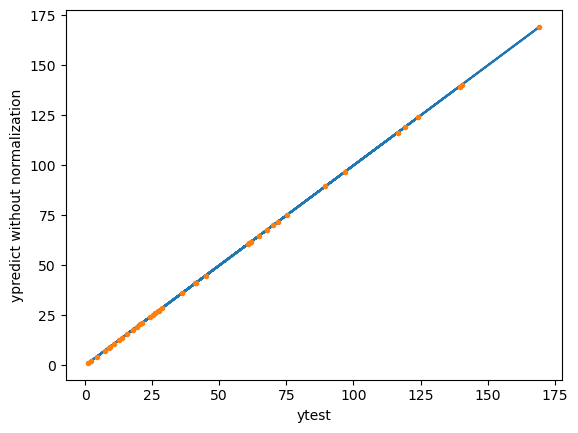

In [35]:
plt.figure()
plt.plot(y_valid,y_valid)
plt.plot(y_valid,y_pred,'.')
plt.xlabel('ytest')
plt.ylabel('ypredict without normalization')
plt.show()

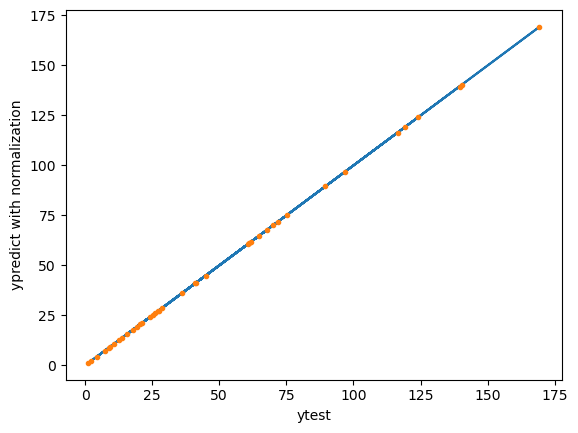

In [36]:
plt.figure()
plt.plot(y_valid,y_valid)
plt.plot(y_valid,y_pred2,'.')
plt.xlabel('ytest')
plt.ylabel('ypredict with normalization')
plt.show()

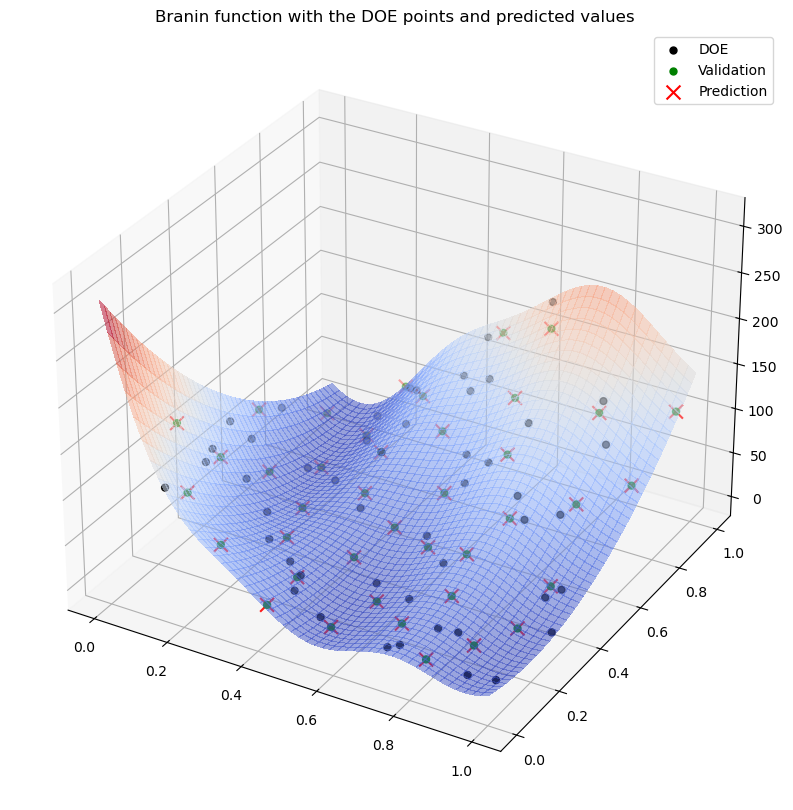

In [37]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

y_train_and_test = branin(x_train_and_test) # branin's function = function to model
x = np.linspace(0,1,50)
res = []
for x0 in x:
    for x1 in x:
        res.append(branin(np.array([[x0,x1]])))
res = np.array(res)
res = res.reshape((50,50)).T
X,Y = np.meshgrid(x,x)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(x_train_and_test[:,0],x_train_and_test[:,1],y_train_and_test,zdir='z',marker = '.',c='k',s=100, label='DOE')
surf = ax.plot_surface(X, Y, res, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,alpha=0.5)
ax.scatter(x_valid[:,0],x_valid[:,1],y_valid,zdir='z',marker = '.',c='g', s=100, label='Validation')
ax.scatter(x_valid[:,0],x_valid[:,1],y_pred,zdir='z',marker = 'x',c='r', s=100, label= 'Prediction')
plt.legend()
plt.title('Branin function with the DOE points and predicted values')

plt.show()

With the visualization of the estimation error

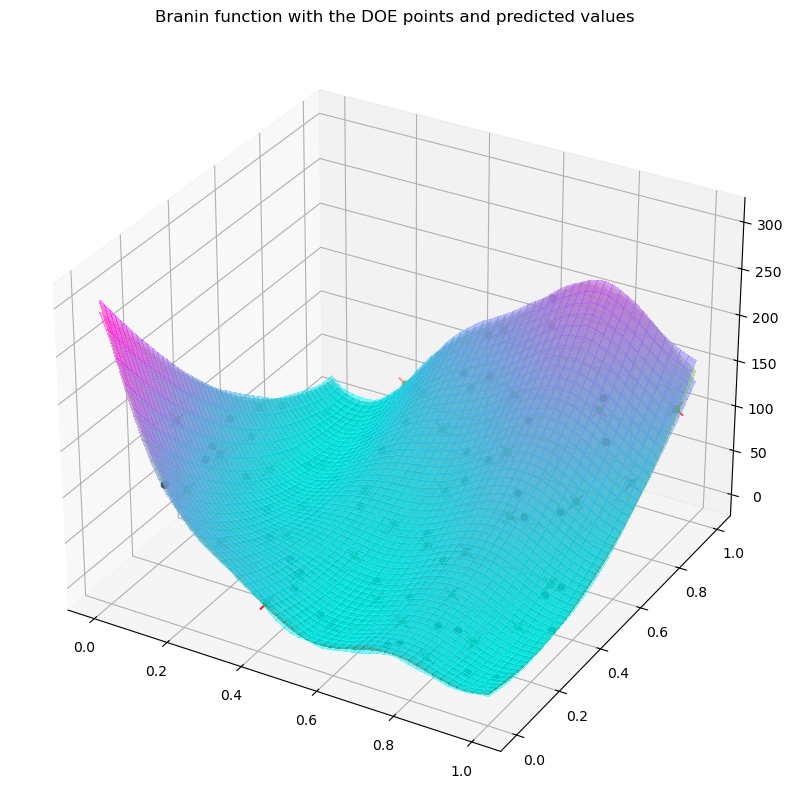

In [38]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

y_train_and_test = branin(x_train_and_test) # branin's function = function to model

x = np.linspace(0,1,50)
res = []
res_y_pred= []
res_sigma_pred = []
for x0 in x:
    for x1 in x:
        res.append(branin(np.array([[x0,x1]])))
        y , s = gpr.predict(np.array([[x0,x1]]), return_std=True)
        res_y_pred.append(y)
        res_sigma_pred.append(s)
res = np.array(res)
res = res.reshape((50,50)).T
res_y_pred = np.array(res_y_pred)
res_y_pred = res_y_pred.reshape((50,50)).T
res_sigma_pred = np.array(res_sigma_pred)
res_sigma_pred = res_sigma_pred.reshape((50,50)).T

X,Y = np.meshgrid(x,x)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(x_train_and_test[:,0],x_train_and_test[:,1],y_train_and_test,zdir='z',marker = '.',c='k',s=100, label='DOE')
#surf = ax.plot_surface(X, Y, res, cmap=cm.coolwarm,
#                       linewidth=0, antialiased=False,alpha=0.5)
surf = ax.plot_surface(X, Y, res_y_pred, cmap=cm.summer,
                       linewidth=0, antialiased=False,alpha=0.5)

surf = ax.plot_surface(X, Y, res_y_pred - 3 * res_sigma_pred , cmap=cm.cool,
                       linewidth=0, antialiased=False,alpha=0.5, label='error')
surf = ax.plot_surface(X, Y, res_y_pred + 3 * res_sigma_pred , cmap=cm.cool,
                       linewidth=0, antialiased=False,alpha=0.5)

ax.scatter(x_valid[:,0],x_valid[:,1],y_valid,zdir='z',marker = '.',c='g', s=100, label='Validation')
ax.scatter(x_valid[:,0],x_valid[:,1],y_pred,zdir='z',marker = 'x',c='r', s=100, label='Prediction')
#plt.legend()
plt.title('Branin function with the DOE points and predicted values')

plt.show()

<p class="alert alert-success" style="padding:1em">
To use SMT models, please follow this link : https://github.com/SMTorg/SMT/blob/master/README.md. The doc is available here: http://smt.readthedocs.io/en/latest/
</p>

<p class="bg-primary" style="padding:1em">**Exercice**: Approximation of the Rosenbrock function in 2D </p>

Rosenbrock Function  in dimension N

$$
f(\mathbf{x}) = \sum_{i=1}^{N-1} 100 (x_{i+1} - x_i^2 )^2 + (1-x_i)^2 \quad \mbox{where} \quad \mathbf{x} = [x_1, \ldots, x_N] \in \mathbb{R}^N.
$$

$$x_i \in [-2,2]$$
    
    
    

In 2D,
 - Try different DOE with different numbers of points for the training database
 - Try different kernels 
    
in order to minimize the RMSE on a validation database
    
    
    
   

In [39]:
def rosenbrock(x):
    """
    Evaluate objective and constraints for the Rosenbrock test case:
    """
    n,dim = x.shape

    #parameters:
    Opt =[]
    Opt_point_scalar = 1
    #construction of O vector
    for i in range(0, dim):
        Opt.append(Opt_point_scalar)

    #Construction of Z vector
    Z= np.zeros((n,dim))
    for i in range(0,dim):
        Z[:,i] = (x[:,i]-Opt[i]+1)

    #Sum
    sum1 = np.zeros((n,1))
    for i in range(0,dim-1):
        sum1[:,0] += 100*(((Z[:,i]**2)-Z[:,i+1])**2)+((Z[:,i]-1)**2)

    return sum1


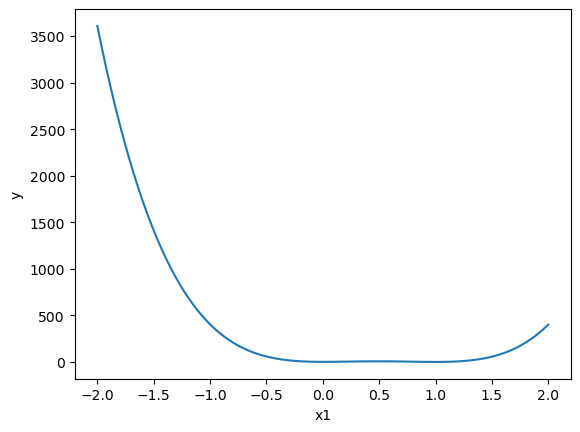

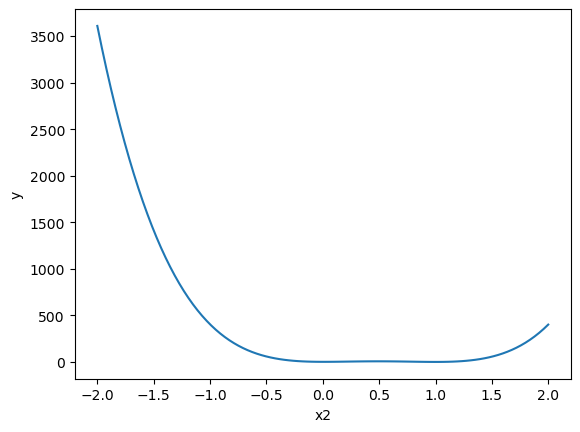

In [40]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

num = 100
ndim = 2
x = np.ones((num, ndim))
x[:, 0] = np.linspace(-2, 2., num)
x[:, 1] = np.linspace(-2, 2., num)
y = rosenbrock(x)


plt.plot(x[:, 0], y[:])
plt.xlabel('x1')
plt.ylabel('y')
plt.show()

plt.plot(x[:, 1], y[:])
plt.xlabel('x2')
plt.ylabel('y')
plt.show()


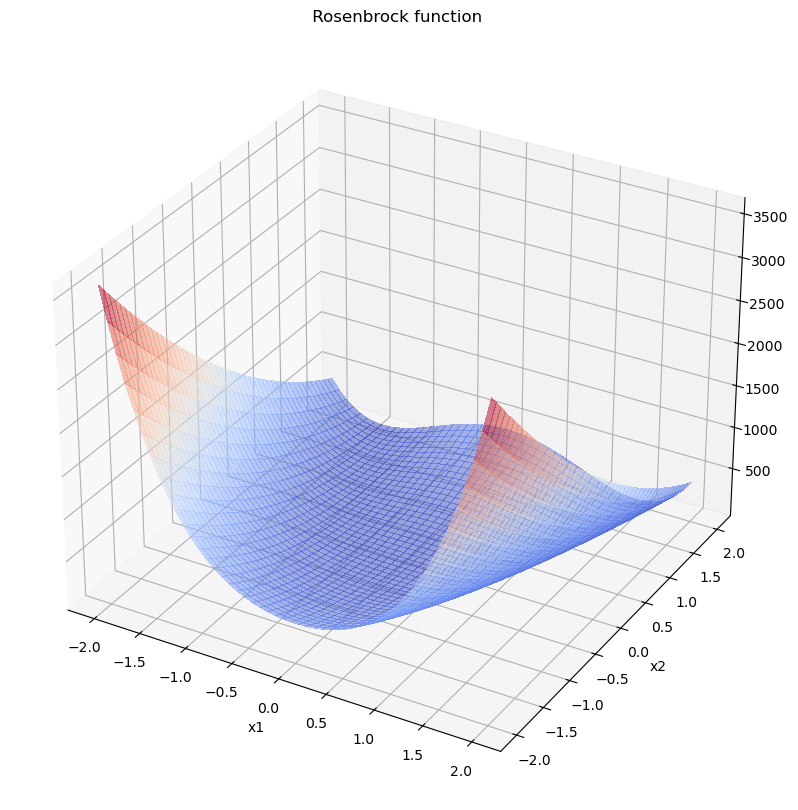

In [41]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


#To plot the Rosenbrock function
x = np.linspace(-2,2,50)
res = []
for x0 in x:
    for x1 in x:
        res.append(rosenbrock(np.array([[x0,x1]])))
res = np.array(res)
res = res.reshape((50,50)).T
X,Y = np.meshgrid(x,x)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, res, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,alpha=0.5)
plt.title(' Rosenbrock function')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

<p class="bg-primary" style="padding:1em">**Exercice**: Use GP to approximate the radar dataset </p>

<p class="bg-primary" style="padding:1em">**Bayesian Optimization **: Use GP to optimize  the sin function based on the tutorial   Tutorial_BO</p>

## Recap: Play with a web app from Rasmussen

https://distill.pub/2019/visual-exploration-gaussian-processes/

[http://www.infinitecuriosity.org/vizgp/](http://www.infinitecuriosity.org/vizgp/)